# [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Usage

1. Go through the [paper] to understand what the data is about.
1. Download some datasets from <https://github.com/mdeff/fma>.
1. Uncompress the archives, e.g. with `unzip fma_small.zip`.
1. Load and play with the data in this notebook.

[paper]: https://arxiv.org/abs/1612.01840

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns


In [3]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import utils
from sklearn.metrics import accuracy_score

plt.rcParams['figure.figsize'] = (17, 5)

In [23]:
# Directory where mp3 are stored.
# AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
# tracks = utils.load('data/fma_metadata/tracks.csv')
# genres = utils.load('data/fma_metadata/genres.csv')
# features = utils.load('data/fma_metadata/features.csv')
# echonest = utils.load('data/fma_metadata/echonest.csv')
# For Alice because she keeps her data in a different place :|
tracks = utils.load('/Volumes/GENRE_DATA/fma_metadata/tracks.csv')
genres = utils.load('/Volumes/GENRE_DATA/fma_metadata/genres.csv')
features = utils.load('/Volumes/GENRE_DATA/fma_metadata/features.csv')
echonest = utils.load('/Volumes/GENRE_DATA/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [24]:
# AUDIO_DIR = "data/fma_small"
#For alice
AUDIO_DIR = "/Volumes/GENRE_DATA/fma_small"

## 1 Metadata

The metadata table, a CSV file in the `fma_metadata.zip` archive, is composed of many colums:
1. The index is the ID of the song, taken from the website, used as the name of the audio file.
2. Per-track, per-album and per-artist metadata from the Free Music Archive website.
3. Two columns to indicate the subset (small, medium, large) and the split (training, validation, test).

In [6]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


### 1.1 Subsets

The small and medium subsets can be selected with the below code.

In [7]:
small = tracks[tracks['set', 'subset'] <= 'small']
small.shape

(8000, 52)

In [8]:
small['track'].groupby('genre_top').size()


genre_top
Blues                     0
Classical                 0
Country                   0
Easy Listening            0
Electronic             1000
Experimental           1000
Folk                   1000
Hip-Hop                1000
Instrumental           1000
International          1000
Jazz                      0
Old-Time / Historic       0
Pop                    1000
Rock                   1000
Soul-RnB                  0
Spoken                    0
dtype: int64

In [9]:
medium = tracks[tracks['set', 'subset'] <= 'medium']
medium.shape

(25000, 52)

## 2 Genres

The genre hierarchy is stored in `genres.csv` and distributed in `fma_metadata.zip`.

In [10]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


## 3 Features

1. Features extracted from the audio for all tracks.
2. For some tracks, data colected from the [Echonest](http://the.echonest.com/) API.

In [12]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 106574 tracks


### 3.1 Echonest features

In [13]:
print('{1} features for {0} tracks'.format(*echonest.shape))
ipd.display(echonest['echonest', 'metadata'].head())
ipd.display(echonest['echonest', 'audio_features'].head())
ipd.display(echonest['echonest', 'social_features'].head())
ipd.display(echonest['echonest', 'ranks'].head())

249 features for 13129 tracks


,album_date,album_name,artist_latitude,artist_location,artist_longitude,artist_name,release
track_id,,,,,,,
2,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
3,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
5,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
10,2008-03-11,Constant Hitmaker,39.9523,"Philadelphia, PA, US",-75.1624,Kurt Vile,Constant Hitmaker
134,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss
track_id,,,,,
2,0.388990,0.386740,0.406370,0.000000,0.000000
3,0.388990,0.386740,0.406370,0.000000,0.000000
5,0.388990,0.386740,0.406370,0.000000,0.000000
10,0.557339,0.614272,0.798387,0.005158,0.354516
134,0.388990,0.386740,0.406370,0.000000,0.000000


,artist_discovery_rank,artist_familiarity_rank,artist_hotttnesss_rank,song_currency_rank,song_hotttnesss_rank
track_id,,,,,
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
10,2635.0,2544.0,397.0,115691.0,67609.0
134,NaN,NaN,NaN,NaN,NaN


,000,001,002,003,004,005,006,007,008,009,...,214,215,216,217,218,219,220,221,222,223
track_id,,,,,,,,,,,,,,,,,,,,,
2,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
3,0.534429,0.537414,0.443299,0.390879,0.344573,0.366448,0.419455,0.747766,0.460901,0.392379,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
5,0.548093,0.720192,0.389257,0.344934,0.361300,0.402543,0.434044,0.388137,0.512487,0.525755,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
10,0.311404,0.711402,0.321914,0.500601,0.250963,0.321316,0.734250,0.325188,0.373012,0.235840,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
134,0.610849,0.569169,0.428494,0.345796,0.376920,0.460590,0.401371,0.449900,0.428946,0.446736,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


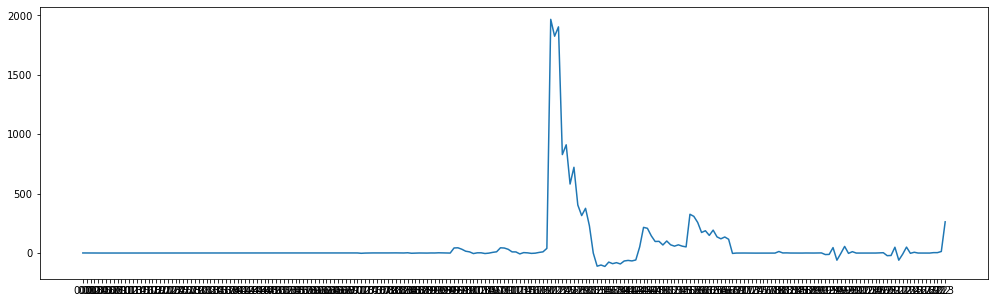

In [14]:
ipd.display(echonest['echonest', 'temporal_features'].head())
x = echonest.loc[2, ('echonest', 'temporal_features')]
plt.plot(x);

### 3.2 Features like MFCCs are discriminant

((2000, 2), (2000,))

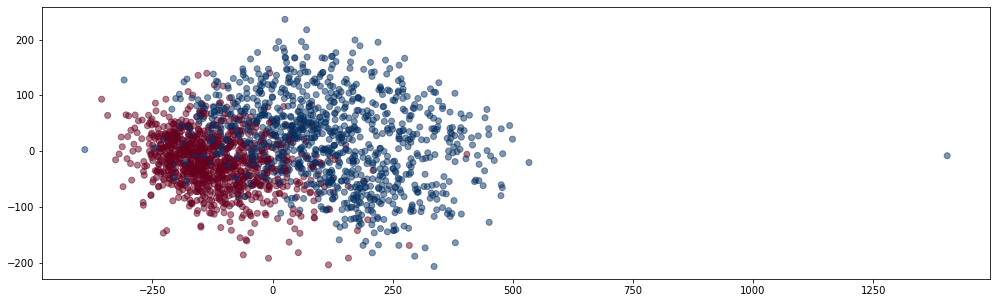

In [15]:
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

## 4 Audio

You can load the waveform and listen to audio in the notebook itself.

In [16]:
## START BHAVNA SECTION


In [26]:
small = tracks[tracks['set', 'subset'] <= 'small']
small = small.sample(frac=1)
small

album                                                             \
         comments        date_created date_released       engineer favorites   
track_id                                                                       
715             0 2008-11-26 02:17:08    2008-03-18            NaN         2   
35199           1 2010-09-03 18:07:09    2010-08-09            NaN         0   
64893           0 2012-05-15 19:31:24    2012-05-12            NaN         0   
110440          0 2014-10-30 18:07:49    2014-10-30   Matt Marando         1   
73765          10 2012-12-11 18:25:56           NaT            NaN         6   
...           ...                 ...           ...            ...       ...   
44800           0 2011-03-01 16:22:28           NaT            NaN         7   
58063           0 2011-12-24 23:13:09    1998-02-14  Chuck Bettis          0   
141735          2 2014-10-28 09:51:55    2015-10-27            NaN         4   
78038           0 2013-01-31 16:31:04    2013-01-14      Mark Koch         0   
52393           0 2011-08-10 11:13:18           NaT            NaN         0   

                                                                            \
             id                                        information listens   
track_id                                                                     
715         203  <p><span class="style6">"Kobold Moon" CD relea...    5100   
35199      7237  <p>\n</p><p style="font-family:'Lucida Grande'...    8827   
64893     11694                                                NaN   16283   
110440    17108  <p> </p>\n<p class="p1">Michael Chapman is a B...    8772   
73765     13057  <p>A European musical tribute to - and celebra...  182231   
...         ...                                                ...     ...   
44800      8698                                                NaN   67522   
58063     10717  <p>FULL ALBUM ON BANDCAMP, GET IT HERE:</p>\n<...    5823   
141735    17087                                                NaN   89788   
78038     13414  <p>Airborne Event is pleased to welcome the ex...    1909   
52393      9826                                                NaN    1721   

                                                                          ...  \
             producer                                               tags  ...   
track_id                                                                  ...   
715               NaN                                                 []  ...   
35199             NaN                                                 []  ...   
64893             NaN                                                 []  ...   
110440    Joe McGasko                                                 []  ...   
73765             NaN                                                 []  ...   
...               ...                                                ...  ...   
44800             NaN  [kid-friendly, childrens music, outer space, s...  ...   
58063             NaN                                                 []  ...   
141735            NaN  [dance, dance music, electronic pop, electroni...  ...   
78038       Dan Bodah                                                 []  ...   
52393             NaN                                                 []  ...   

               track                         \
         information interest language_code   
track_id                                      
715              NaN     1526            en   
35199            NaN     1930           NaN   
64893            NaN     1889           NaN   
110440           NaN     1574           NaN   
73765            NaN     3436           NaN   
...              ...      ...           ...   
44800            NaN     3423           NaN   
58063            NaN     3749           NaN   
141735           NaN    11061           NaN   
78038            NaN     1153           NaN   
52393            NaN     2498           NaN   

    

In [40]:
import warnings

audioData = small['track'][['genre_top']].head(300)
audioData = audioData[audioData.index != 99134]

def create_standardized_table(input_table):
    input_table['filename'] = input_table.apply(lambda row : utils.get_audio_path(AUDIO_DIR, row.name), axis = 1) 
    input_table['xsr'] = input_table.apply(lambda row: librosa.load(row['filename'], sr=None, mono=True, duration = 30), axis = 1)
    input_table['stft'] = input_table.apply(lambda row: np.abs(librosa.stft(row['xsr'][0], n_fft=2048, hop_length=512)), axis = 1)
    input_table['mel_spect'] = input_table.apply(lambda row: librosa.feature.melspectrogram(sr=row['xsr'][1], S=row['stft']**2), axis = 1)
    input_table['mel_log'] = input_table.apply(lambda row: librosa.amplitude_to_db(row['mel_spect']), axis = 1)
    input_table["mfcc"] = input_table.apply(lambda row: librosa.feature.mfcc(S=librosa.power_to_db(row["mel_log"]), n_mfcc=20), axis = 1)
    input_table["mfcc_scaled"] = input_table.apply(lambda row: skl.preprocessing.StandardScaler().fit_transform(row["mfcc"]), axis = 1)
    input_table["mfcc_middle_time"] = input_table.apply(lambda row: row["mfcc_scaled"][:, :2581], axis = 1)
#     input_table["mfcc_shape"] = input_table.apply(lambda row: row["mfcc_cut_off"].shape, axis = 1)
    #throw away rows with nonsense mfcc shape
#     input_table = input_table[input_table["mfcc_shape"] == (20, 2581)]
    input_table['mfcc_with_channel'] = input_table.apply(lambda row: np.reshape(row['mfcc_middle_time'], row['mfcc_middle_time'].shape + (1,)), axis = 1)
#     datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization = True)
#     datagen.fit(np.stack(input_table['mel_log_with_channel']))
#     input_table['mel_log_normalized'] = input_table.apply(lambda row: (row['mel_log_with_channel'] - datagen.mean)/datagen.std, axis = 1)

    return input_table
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    audioData = create_standardized_table(audioData)
    #merging spectral centroid features
#     audioData = features['spectral_centroid'][[('median', '01'), ('skew', '01'), ('std', '01'), ('mean', '01')]].merge(audioData, left_on = 'track_id', right_on = 'track_id')
#     audioData = audioData.rename(columns = {('median', '01'): 'sc_median', ('skew', '01'): 'sc_skew', ('std', '01'): 'sc_std', ('mean', '01'): 'sc_mean'})
     #merging zcr features
#     audioData = features['zcr'][[('median', '01'), ('skew', '01'), ('std', '01'), ('mean', '01'), ('kurtosis', '01'), ('min', '01'), ('max', '01')]].merge(audioData, left_on = 'track_id', right_on = 'track_id')
#     audioData = audioData.rename(columns = {('median', '01'): 'zcr_median', ('skew', '01'): 'zcr_skew', ('std', '01'): 'zcr_std', ('mean', '01'): 'zcr_mean', ('kurtosis', '01'): 'zcr_kurtosis', ('min', '01'): 'zcr_min', ('max', '01'): 'zcr_max'})
    #merging rmse features
#     audioData = features['rmse'][[('median', '01'), ('skew', '01'), ('std', '01'), ('mean', '01'), ('kurtosis', '01'), ('min', '01'), ('max', '01')]].merge(audioData, left_on = 'track_id', right_on = 'track_id')
#     audioData = audioData.rename(columns = {('median', '01'): 'rmse_median', ('skew', '01'): 'rmse_skew', ('std', '01'): 'rmse_std', ('mean', '01'): 'rmse_mean', ('kurtosis', '01'): 'rmse_kurtosis', ('min', '01'): 'rmse_min', ('max', '01'): 'rmse_max'})
    #merging echonest features (IGNORING FOR NOW)
audioData.columns

Index(['genre_top', 'filename', 'xsr', 'stft', 'mel_spect', 'mel_log', 'mfcc',
       'mfcc_scaled', 'mfcc_middle_time', 'mfcc_with_channel'],
      dtype='object')

In [ ]:
audioData['mfcc_with_channel']

In [21]:
#random forests to decide best features
X_rf = audioData[['rmse_median', 'rmse_skew', 'rmse_std', 'rmse_mean', 'rmse_kurtosis',
       'rmse_min', 'rmse_max', 'zcr_median', 'zcr_skew', 'zcr_std', 'zcr_mean',
       'zcr_kurtosis', 'zcr_min', 'zcr_max', 'sc_median', 'sc_skew', 'sc_std',
       'sc_mean']]
Y_rf = audioData['genre_top']
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_rf, Y_rf)
sel.get_support()
selected_feat= X_rf.columns[(sel.get_support())]
len(selected_feat)
print(selected_feat)
dropped_features = X_rf.columns[(~sel.get_support())]
dropped_features

Index(['rmse_median', 'rmse_std', 'rmse_mean', 'rmse_max', 'zcr_std',
       'sc_median', 'sc_skew', 'sc_std', 'sc_mean'],
      dtype='object')


Index(['rmse_skew', 'rmse_kurtosis', 'rmse_min', 'zcr_median', 'zcr_skew',
       'zcr_mean', 'zcr_kurtosis', 'zcr_min', 'zcr_max'],
      dtype='object')

In [23]:
sel = RandomForestClassifier(n_estimators = 100)
sel.fit(X_train[['rmse_median', 'rmse_skew', 'rmse_std', 'rmse_mean', 'rmse_kurtosis',
       'rmse_min', 'rmse_max', 'zcr_median', 'zcr_skew', 'zcr_std', 'zcr_mean',
       'zcr_kurtosis', 'zcr_min', 'zcr_max', 'sc_median', 'sc_skew', 'sc_std',
       'sc_mean']], Y_train)
y_pred = sel.predict(X_val[['rmse_median', 'rmse_skew', 'rmse_std', 'rmse_mean', 'rmse_kurtosis',
       'rmse_min', 'rmse_max', 'zcr_median', 'zcr_skew', 'zcr_std', 'zcr_mean',
       'zcr_kurtosis', 'zcr_min', 'zcr_max', 'sc_median', 'sc_skew', 'sc_std',
       'sc_mean']])
accuracy_score(Y_val, y_pred)

NameError: name 'X_train' is not defined

In [8]:
#drop useless columns
# audioData = audioData.drop(dropped_features, axis = 1)
# audioData.columns

Index(['rmse_std', 'rmse_mean', 'rmse_max', 'zcr_median', 'zcr_mean',
       'sc_median', 'sc_skew', 'sc_std', 'sc_mean', 'genre_top', 'filename',
       'xsr', 'stft', 'mel_spect', 'mel_log', 'mfcc', 'mfcc_scaled',
       'mfcc_cut_off', 'mfcc_shape', 'mfcc_with_channel'],
      dtype='object')

In [24]:
audioData.columns

Index(['rmse_median', 'rmse_skew', 'rmse_std', 'rmse_mean', 'rmse_kurtosis',
       'rmse_min', 'rmse_max', 'zcr_median', 'zcr_skew', 'zcr_std', 'zcr_mean',
       'zcr_kurtosis', 'zcr_min', 'zcr_max', 'sc_median', 'sc_skew', 'sc_std',
       'sc_mean', 'genre_top', 'filename', 'xsr', 'stft', 'mel_spect',
       'mel_log', 'mfcc', 'mfcc_scaled', 'mfcc_cut_off', 'mfcc_shape',
       'mfcc_with_channel'],
      dtype='object')

In [25]:
audioData.shape

(298, 29)

In [26]:
audioData["mfcc_with_channel"].iloc[0].shape

(20, 2581, 1)

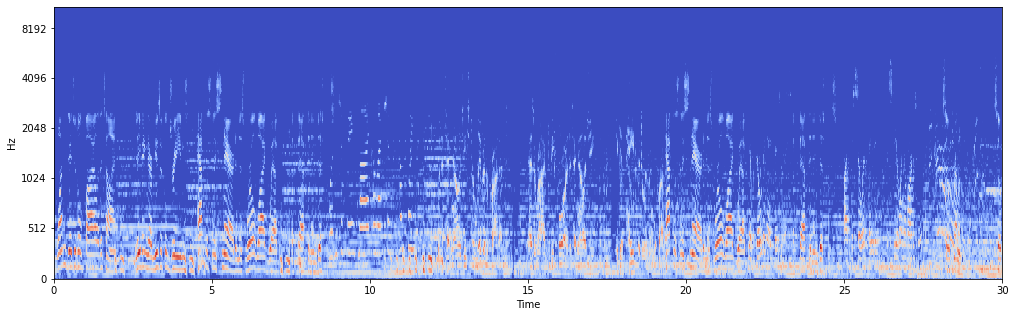

In [27]:
test = audioData.iloc[1]
librosa.display.specshow(test["mel_log"], sr=test["xsr"][1], hop_length=512, x_axis='time', y_axis='mel');

(20, 2584)

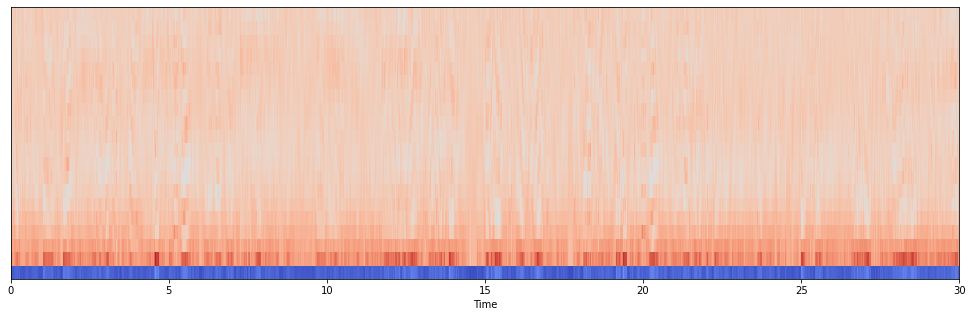

In [38]:
librosa.display.specshow(test["mfcc_scaled"][0:20, 0:2584], sr=test["xsr"][1], x_axis='time');
test["mfcc_scaled"].shape

In [36]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(audioData.drop('genre_top', inplace=False, axis = 1), audioData['genre_top'], test_size=0.25, random_state=24)

In [37]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.5, random_state=24)

In [38]:
# Just conv
firstInput = tf.keras.Input(shape= (64,173,1))
layer1 = layers.Conv2D(300, (2,2), activation='relu', padding = 'same', input_shape=(20, 800, 1))(firstInput)
# layer2 = layers.Dropout(.4)(layer1)
layer3 = layers.MaxPooling2D((2, 2))(layer1)
layer4 = layers.Conv2D(200, (3, 3), activation='relu',  use_bias = True)(layer3)
layer5 = layers.MaxPooling2D((2, 2))(layer4)
dropout1 = layers.Dropout(.3)(layer5)
layer6 = layers.Conv2D(200, (3, 3), activation='relu',  use_bias = True)(dropout1)
layer7 = layers.MaxPooling2D((2, 2))(layer6)
dropout2 = layers.Dropout(.3)(layer7)
# layer5 = layers.Dropout(.3)(layer4)
layer8 = layers.Flatten()(dropout2)
layer9 = layers.Dense(64, activation='relu', use_bias = True)(layer8)
layer10 = layers.Dense(32, activation='relu', use_bias = True)(layer9)
layer11 = layers.Dense(10, activation = 'softmax', use_bias = True)(layer10)
convModel = tf.keras.Model(inputs= firstInput, outputs = layer11)
convModel.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 173, 1)]      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 173, 300)      1500      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 86, 300)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 84, 200)       540200    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 42, 200)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 42, 200)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 40, 200)       3602

In [32]:
#just features
newInput = tf.keras.Input(shape = (9,))
# layer9 = layers.Dense(8, activation='relu', use_bias = True)(layer8)
layer1 = layers.Dense(8, activation='relu', use_bias = True)(newInput)
layer2 = layers.Dense(8, activation='relu', use_bias = True)(layer1)
layer3 = layers.Dropout(.1)(layer2)
layer4 = layers.Dense(8, activation='relu', use_bias = True)(layer3)
layer5 = layers.Dense(8, use_bias = True)(layer4)
featureModel = tf.keras.Sequential(inputs= newInput, outputs = layer5)

featureModel.summary()

TypeError: __init__() got an unexpected keyword argument 'inputs'

In [33]:
# Combining model cell

firstInput = tf.keras.Input(shape= (20, 2581, 1))
layer1 = layers.Conv2D(300, (2,2), activation='relu', padding = 'same', input_shape=(20, 2581, 1), kernel_regularizer =tf.keras.regularizers.l2( l=.15))(firstInput)
layer2 = layers.Dropout(.4)(layer1)
layer3 = layers.MaxPooling2D((2, 2))(layer2)
layer4 = layers.Conv2D(200, (3, 3), activation='relu',  use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=.15))(layer3)
layer5 = layers.Dropout(.3)(layer4)
layer6 = layers.Flatten()(layer5)
layer7 = layers.Dense(64, activation='relu', use_bias = True)(layer6)
newInput = tf.keras.Input(shape = (9,))
layer8 = layers.concatenate([layer7, newInput])
# layer9 = layers.Dense(8, activation='relu', use_bias = True)(layer8)
layer10 = layers.Dense(32, activation='relu', use_bias = True)(layer8)
layer11 = layers.Dense(8, use_bias = True)(layer10)
model = tf.keras.Model(inputs= [firstInput, newInput], outputs = layer11)
# model = tf.keras.Model(inputs= firstInput, outputs = layer11)

# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu', use_bias = True))

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20, 2581, 1) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 20, 2581, 300 1500        input_3[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 20, 2581, 300 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 10, 1290, 300 0           dropout_3[0][0]                  
____________________________________________________________________________________________

In [32]:
conv2model = models.Sequential()
conv2model.add(layers.Conv2D(72, (4,4), activation='relu', padding = 'same', input_shape=(20, 800, 1), kernel_regularizer =tf.keras.regularizers.l2( l=.15)))
conv2model.add(layers.BatchNormalization())
conv2model.add(layers.MaxPooling2D((3, 3)))
conv2model.add(layers.Conv2D(64, (3, 3), activation='relu',  use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=.15)))
conv2model.add(layers.Dropout(.2))
conv2model.add(layers.MaxPooling2D((2, 2)))
# conv2model.add(layers.Conv2D(64, (2, 2), activation='relu'))
# conv2model.add(layers.BatchNormalization())
# conv2model.add(layers.MaxPooling2D((2, 2)))
conv2model.add(layers.Flatten())
conv2model.add(layers.Dense(64, activation='relu', use_bias = True))
conv2model.add(layers.Dense(8, use_bias = True))
conv2model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 20, 800, 72)       1224      
_________________________________________________________________
batch_normalization_19 (Batc (None, 20, 800, 72)       288       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 6, 266, 72)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 4, 264, 64)        41536     
_________________________________________________________________
dropout_22 (Dropout)         (None, 4, 264, 64)        0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 2, 132, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16896)           

In [38]:
label_dict = {
 'Electronic': 0,
 'Experimental': 1,
 'Folk': 2,
 'Hip-Hop': 3,
 'Instrumental': 4,
 'International': 5,
 'Pop': 6,
 'Rock': 7
}
Y_train = Y_train.replace(label_dict)
Y_val = Y_val.replace(label_dict)
Y_test = Y_test.replace(label_dict)

In [158]:
#cross validation to find best regularization parameters 
## NOT CURRENTLY USED
fold_no = 1
k_fold = KFold(n_splits=15)
for train_indices, test_indices in k_fold.split(X_train):
    reg_param = 0.00015 * fold_no
    model = models.Sequential()
    model.add(layers.Conv2D(120, (4,4), activation='relu', padding = 'same', input_shape=(10, frequency_cutoff, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',  use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=reg_param)))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu', use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=reg_param)))
    model.add(layers.Dense(8, use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=reg_param)))
    model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    history = model.fit(np.stack(X_train.iloc[train_indices]['mel_log_with_channel']), np.asarray(Y_train.iloc[train_indices]), epochs=5)
    scores = model.evaluate(np.stack(X_train.iloc[test_indices]['mel_log_with_channel']), np.asarray(Y_train.iloc[test_indices]), verbose=0)
    print(f'Score for fold {fold_no} with reg_param {reg_param}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    fold_no = fold_no + 1


NameError: name 'frequency_cutoff' is not defined

In [13]:
model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit([np.stack(X_train['mfcc_with_channel']), np.stack(X_train[selected_feat].values)], np.asarray(Y_train), batch_size = 40, epochs=40, 
                validation_data=([np.stack(X_val['mfcc_with_channel']), np.stack(X_val[selected_feat].values)], np.asarray(Y_val)))
# history = model.fit(np.stack(X_train['mfcc_with_channel']), np.asarray(Y_train), batch_size = 40, epochs=40, 
#                 validation_data=(np.stack(X_val['mfcc_with_channel']), np.asarray(Y_val)))

Train on 111 samples, validate on 112 samples
Epoch 1/40
111/111 [==============================] - 1730s 16s/sample - loss: 280.4618 - accuracy: 0.1351 - val_loss: 176.8666 - val_accuracy: 0.0804
Epoch 2/40
111/111 [==============================] - 1371s 12s/sample - loss: 149.8182 - accuracy: 0.1532 - val_loss: 133.5432 - val_accuracy: 0.1429
Epoch 3/40
111/111 [==============================] - 1319s 12s/sample - loss: 120.8074 - accuracy: 0.2703 - val_loss: 103.2834 - val_accuracy: 0.1875
Epoch 4/40
111/111 [==============================] - 1119s 10s/sample - loss: 101.6406 - accuracy: 0.2703 - val_loss: 110.9057 - val_accuracy: 0.1518
Epoch 5/40
111/111 [==============================] - 1206s 11s/sample - loss: 90.8680 - accuracy: 0.0991 - val_loss: 81.6883 - val_accuracy: 0.1071
Epoch 6/40
111/111 [==============================] - 1452s 13s/sample - loss: 83.7958 - accuracy: 0.2523 - val_loss: 75.6329 - val_accuracy: 0.1161
Epoch 7/40
111/111 [==============================] 

KeyboardInterrupt: 

In [32]:
featureModel.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = featureModel.fit(X_train[selected_feat + dropped_features].values, np.asarray(Y_train), batch_size = 50, epochs=200, 
                validation_data=(X_val[selected_feat + dropped_features].values, np.asarray(Y_val)))
# history = model.fit(np.stack(X_train['mfcc_with_channel']), np.asarray(Y_train), batch_size = 40, epochs=40, 
#                 validation_data=(np.stack(X_val['mfcc_with_channel']), np.asarray(Y_val)))

KeyError: "None of [Index(['rmse_stdrmse_median', 'rmse_meanrmse_skew', 'rmse_maxrmse_kurtosis',\n       'zcr_medianrmse_min', 'zcr_meanzcr_skew', 'sc_medianzcr_std',\n       'sc_skewzcr_kurtosis', 'sc_stdzcr_min', 'sc_meanzcr_max'],\n      dtype='object')] are in the [columns]"

In [71]:
optimizer_input=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
convModel.compile(optimizer=optimizer_input,
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = convModel.fit(np.stack(X_train['mfcc_with_channel']), np.asarray(Y_train), batch_size = 40, epochs=40, 
                validation_data=(np.stack(X_val['mfcc_with_channel']), np.asarray(Y_val)))

ValueError: all input arrays must have the same shape

In [39]:
conv2model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = conv2model.fit(np.stack(X_train['mfcc_with_channel']), np.asarray(Y_train), batch_size = 40, epochs=40, 
                validation_data=(np.stack(X_val['mfcc_with_channel']), np.asarray(Y_val)))

ValueError: all input arrays must have the same shape

In [60]:
Y_val.value_counts()[2]/len(Y_val)

0.11504424778761062

In [61]:
#see which ones it's predicting wrong
val_predictions = model.predict(np.stack(X_val['mfcc_with_channel']))
predictions = []
two_count = 0
for arr in val_predictions:
    predictions.append(np.argmax(arr))
predictions

[2,
 1,
 7,
 1,
 2,
 7,
 0,
 7,
 0,
 4,
 2,
 7,
 7,
 1,
 7,
 7,
 1,
 4,
 4,
 1,
 0,
 2,
 2,
 7,
 0,
 4,
 7,
 7,
 0,
 7,
 7,
 7,
 7,
 4,
 2,
 0,
 0,
 7,
 5,
 7,
 5,
 2,
 4,
 0,
 7,
 7,
 1,
 7,
 0,
 0,
 4,
 7,
 5,
 2,
 4,
 2,
 7,
 0,
 7,
 7,
 2,
 2,
 7,
 7,
 7,
 0,
 7,
 0,
 7,
 4,
 7,
 4,
 0,
 7,
 7,
 1,
 1,
 1,
 4,
 0,
 0,
 4,
 1,
 7,
 1,
 7,
 0,
 0,
 1,
 4,
 7,
 0,
 0,
 5,
 2,
 7,
 7,
 1,
 4,
 2,
 0,
 0,
 7,
 4,
 0,
 4,
 2,
 7,
 2,
 7,
 1,
 7,
 2]

In [62]:
correctness_arr = [0, 0, 0, 0, 0, 0, 0, 0]
for x in range(0, len(predictions)):
    if predictions[x] == Y_val.iloc[x]:
        correctness_arr[predictions[x]] += 1
for y in range(0, 8):
    if y in Y_val.value_counts():
        correctness_arr[y] = str(correctness_arr[y]) + "/" + str(Y_val.value_counts()[y])
    
correctness_arr
    

['4/19', '4/17', '3/13', '0/15', '2/10', '0/12', '0/15', '9/12']

In [64]:
#see which ones it's predicting wrong
train_predictions = model.predict(np.stack(X_train['mfcc_with_channel']))
predictions = []
two_count = 0
for arr in train_predictions:
    predictions.append(np.argmax(arr))
correctness_arr = [0, 0, 0, 0, 0, 0, 0, 0]
for x in range(0, len(predictions)):
    if predictions[x] == Y_train.iloc[x]:
        correctness_arr[predictions[x]] += 1
for y in range(0, 8):
    if y in Y_train.value_counts():
        correctness_arr[y] = str(correctness_arr[y]) + "/" + str(Y_train.value_counts()[y])
    
correctness_arr

['11/15', '14/17', '15/16', '0/12', '17/17', '4/11', '0/9', '12/15']

/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


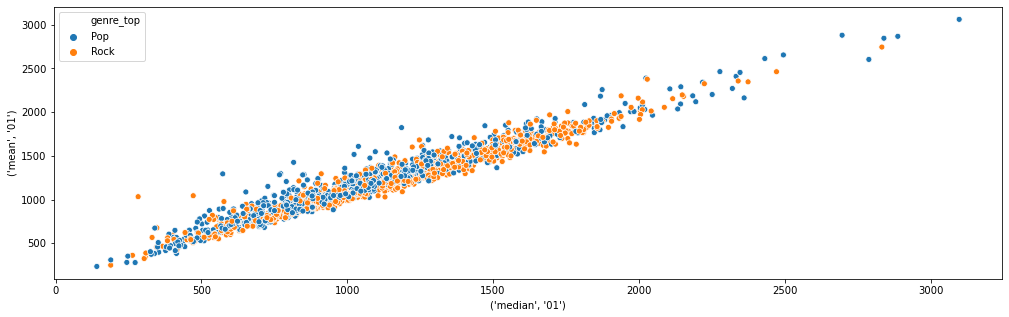

In [17]:
spectral_centroid_table = features['spectral_centroid']
spectral_centroid_table = spectral_centroid_table.merge(small['track'][['genre_top']], left_on = 'track_id', right_on = 'track_id')
spectral_centroid_table.columns
limited_table = spectral_centroid_table[(spectral_centroid_table['genre_top'] == 'Rock') | (spectral_centroid_table['genre_top'] == 'Pop')]
sns.scatterplot(x=('median', '01'), y=('mean', '01'), hue="genre_top",
                data=limited_table)
# plt.scatter(x = spectral_centroid_table['min, 01'], y = spectral_centroid_table['max, 01'], c = spectral_centroid_table['genre_top'])

In [18]:
spectral_centroid_table

#good ones for separating electronic and folk are median, skew, std, mean. add to neural network

,"(kurtosis, 01)","(max, 01)","(mean, 01)","(median, 01)","(min, 01)","(skew, 01)","(std, 01)",genre_top
track_id,,,,,,,,
2,2.406808,5514.049805,1639.583252,1503.496704,0.000000,1.079815,719.770508,Hip-Hop
5,1.322586,5648.614746,1292.958130,1186.514038,0.000000,0.937101,665.319275,Hip-Hop
10,9.729688,5739.394531,1360.028687,1180.966797,0.000000,2.523783,668.700806,Pop
140,2.917819,4728.459961,1232.633789,1068.719605,172.106689,1.610563,726.773254,Folk
141,7.013360,5497.614746,941.244141,860.683472,198.165558,1.933955,442.332092,Folk
148,31.255180,8063.423828,1192.512695,1128.539307,0.000000,3.802624,699.388489,Experimental
182,5.825723,4934.498535,916.347839,888.263672,226.407074,0.938448,226.025040,Rock
190,14.138241,5493.454590,1096.097412,988.822815,562.740967,3.500752,487.713043,Folk
193,8.487834,5830.796387,1064.324585,819.506104,383.290039,2.752520,725.840454,Folk


In [70]:
#neural network based on new featurees
model_new = tf.keras.Sequential()
model_new.add(tf.keras.layers.Dense(8, input_shape=(4,)))
# Afterwards, we do automatic shape inference:
model_new.add(tf.keras.layers.Dense(8))

In [71]:
model_new.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model_new.fit(spectral_centroid_table[[('mean', '01'), ('skew', '01'), ('std', '01'), ('median', '01')]], np.asarray(spectral_centroid_table['genre_top'].replace(label_dict)), batch_size = 40, epochs=40)

Train on 8000 samples
Epoch 1/40
8000/8000 [==============================] - 0s 39us/sample - loss: 482.9969 - acc: 0.1149
Epoch 2/40
8000/8000 [==============================] - 0s 23us/sample - loss: 100.8261 - acc: 0.1076
Epoch 3/40
8000/8000 [==============================] - 0s 23us/sample - loss: 41.0576 - acc: 0.1277
Epoch 4/40
8000/8000 [==============================] - 0s 23us/sample - loss: 10.0832 - acc: 0.1417
Epoch 5/40
8000/8000 [==============================] - 0s 22us/sample - loss: 5.2589 - acc: 0.1570
Epoch 6/40
8000/8000 [==============================] - 0s 21us/sample - loss: 4.6806 - acc: 0.1731
Epoch 7/40
8000/8000 [==============================] - 0s 21us/sample - loss: 4.1165 - acc: 0.1810
Epoch 8/40
8000/8000 [==============================] - 0s 23us/sample - loss: 3.6983 - acc: 0.1787
Epoch 9/40
8000/8000 [==============================] - 0s 22us/sample - loss: 3.3190 - acc: 0.1898
Epoch 10/40
8000/8000 [==============================] - 0s 20us/sample 

In [4]:
def loadall(filename=''):
    tmp = np.load(filename)
    x_tr = tmp['x_tr']
    y_tr = tmp['y_tr']
    x_te = tmp['x_te']
    y_te = tmp['y_te']
    x_cv = tmp['x_cv']
    y_cv = tmp['y_cv']
    return {'x_tr' : x_tr, 'y_tr' : y_tr,
            'x_te' : x_te, 'y_te' : y_te,
            'x_cv' : x_cv, 'y_cv' : y_cv, }

In [5]:
data = loadall('data/melspects.npz')

x_tr = data['x_tr']
y_tr = data['y_tr']
x_te = data['x_te']
y_te = data['y_te']
x_cv = data['x_cv']
y_cv = data['y_cv']

tr_idx = np.random.permutation(len(x_tr))
te_idx = np.random.permutation(len(x_te))
cv_idx = np.random.permutation(len(x_cv))

x_tr = x_tr[tr_idx]
y_tr = y_tr[tr_idx]
x_te = x_te[te_idx]
y_te = y_te[te_idx]
x_cv = x_cv[cv_idx]
y_cv = y_cv[cv_idx]

In [6]:
x_tr_temp = np.reshape(x_tr, x_tr.shape + (1,))
# x_tr_temp.shape
x_cv_temp = np.reshape(x_cv, x_cv.shape + (1,))
x_cv_temp.shape
# x_cv = x_cv.apply(lambda row: np.reshape(row['mfcc_middle_time'], row['mfcc_middle_time'].shape + (1,)), axis = 1)

(100, 64, 173, 1)

In [17]:
extModel = models.Sequential()
extModel.add(tf.keras.layers.Conv2D(64, kernel_size=(4, 4),
                 activation='relu', #kernel_regularizer=regularizers.l2(0.04),
                 input_shape=(64,173,1)))
extModel.add(tf.keras.layers.BatchNormalization())
extModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 4)))
extModel.add(tf.keras.layers.Conv2D(64, (3, 5), activation='relu'
                , kernel_regularizer=tf.keras.regularizers.l2(0.04)
                ))
extModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
extModel.add(tf.keras.layers.Dropout(0.2))
extModel.add(tf.keras.layers.Conv2D(64, (2, 2), activation='relu'
   # , kernel_regularizer=regularizers.l2(0.04)
    ))
extModel.add(tf.keras.layers.BatchNormalization())
extModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
extModel.add(tf.keras.layers.Dropout(0.2))
extModel.add(tf.keras.layers.Flatten())
extModel.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.04)))
extModel.add(tf.keras.layers.Dropout(0.5))
extModel.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.04)))
extModel.add(tf.keras.layers.Dense(10, activation='softmax'))
extModel.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])
history = extModel.fit(x_tr_temp, y_tr, batch_size = 40, epochs=40, 
                validation_data=(x_cv_temp, y_cv))

Train on 8000 samples, validate on 100 samples
Epoch 1/40
8000/8000 [==============================] - 136s 17ms/sample - loss: 6.1876 - accuracy: 0.1934 - val_loss: 3.1381 - val_accuracy: 0.2400
Epoch 2/40
8000/8000 [==============================] - 142s 18ms/sample - loss: 2.4816 - accuracy: 0.3449 - val_loss: 2.3929 - val_accuracy: 0.2400
Epoch 3/40
8000/8000 [==============================] - 139s 17ms/sample - loss: 2.0264 - accuracy: 0.4411 - val_loss: 2.0352 - val_accuracy: 0.4700
Epoch 4/40
8000/8000 [==============================] - 139s 17ms/sample - loss: 1.8793 - accuracy: 0.4913 - val_loss: 1.8807 - val_accuracy: 0.4900
Epoch 5/40
8000/8000 [==============================] - 140s 18ms/sample - loss: 1.8324 - accuracy: 0.5274 - val_loss: 1.8572 - val_accuracy: 0.4900
Epoch 6/40
8000/8000 [==============================] - 139s 17ms/sample - loss: 1.8063 - accuracy: 0.5304 - val_loss: 1.8757 - val_accuracy: 0.5200
Epoch 7/40
8000/8000 [==============================] - 132

KeyboardInterrupt: 

In [125]:
## DONE WITH BHAVNA SECTION

In [127]:
filename = utils.get_audio_path(AUDIO_DIR, 10)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: data/fma_small/000/000010.mp3


/Users/bhavnasud/.local/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Duration: 29.99s, 1322496 samples


And use [librosa](https://github.com/librosa/librosa) to compute spectrograms and audio features.

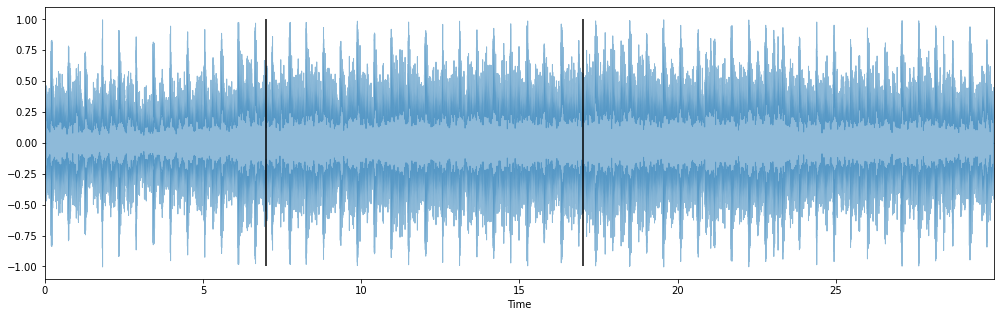

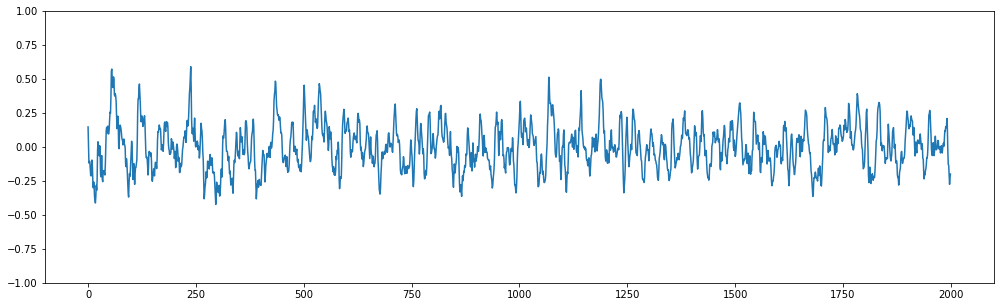

In [20]:
librosa.display.waveplot(x, sr, alpha=0.5);
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1));

In [12]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

NameError: name 'x' is not defined

In [11]:
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time');

NameError: name 'mel' is not defined

## 5 Genre classification

### 5.1 From features

In [47]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train].drop(["mfcc"], axis = 1)
X_test = features.loc[small & test].drop(["mfcc"], axis = 1)

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
378 features, 8 classes


In [49]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 46.88%


### 5.2 From audio